# Desenvolvimento de Score de Crédito para Solicitantes de Empréstimos Pessoais

## Contexto
Como parte dos estudos relacionados a ciência dos dados desenvolvi um modelo que atribui uma pontuação de crédito (score) a novos indivíduos que solicitam empréstimos pessoais. Para a construção do modelo, utilizei uma base de dados composta por três safras empilhadas de clientes que tiveram empréstimos aprovados anteriormente.

## Objetivo
Criar um modelo de credit scoring capaz de prever o risco de crédito de novos solicitantes com base em seu histórico financeiro externo.

## Roteiro Analítico Utilizado

 1. Análise Exploratória da Base de Dados - EDA
   - Examinar a estrutura dos dados
   - Calcular estatísticas descritivas
   - Visualizar distribuições das variáveis
   - Identificar padrões, outliers e valores ausentes
   - Análise do poder preditivo das variáveis (IV)

 2. Análise Bivariada das Variáveis Explicativas versus Variável Resposta
   - Criar visualizações para relações entre variáveis
   - Calcular correlações e realizar testes estatísticos
   - Identificar variáveis potencialmente importantes para o modelo

 3. Construção do Modelo de Regressão Logística Múltipla
   - Selecionar variáveis significativas (95% de confiança)
   - Verificar e tratar colinearidade
   - Ajustar o modelo de regressão logística
   - Interpretar os coeficientes do modelo
   - Avaliação de colinearidade no modelo (VIF)
       
 4. Formulação da Equação do Modelo Final
   - Escrever a equação completa do modelo
   - Explicar o significado dos coeficientes e variáveis

 5. Avaliação de Desempenho do Modelo
   - Criar matriz de confusão
   - Calcular métricas de desempenho (acurácia, precisão, recall, F1-score, AUC-ROC)
   - Analisar a qualidade geral do modelo

 6. Aplicação Prática do Modelo
   - Calcular o score para um cliente específico
   - Interpretar o resultado no contexto da política de crédito do banco

## Considerações Finais
- Discutir a implementação prática do modelo no banco
- Propor melhorias e análises adicionais para futuras iterações

## Obtenção dos Dados

Para esta análise, será utilizado o seguinte arquivo:

* `Credit_Score.txt` 

## Dicionário das Variáveis

* `ID` - Código identificador único do cliente.

* `SAFRA` - Período de seleção do cliente, indicando a coorte de análise.

* `IDADE` - Idade do cliente em anos, uma variável contínua que pode influenciar a análise de perfil.

* `RENDA_MEDIA_MENSAL` - Renda média mensal do cliente nos últimos 12 meses, em R$, um indicador importante para análise de capacidade de pagamento.

* `TOTAL_INVESTIMENTOS` - Valor total em investimentos que o cliente possui em outras instituições financeiras, em R$, uma variável que indica o perfil de investimento.

* `QTDE_CONSULTAS_CREDITO_12M` - Número de consultas de crédito realizadas no nome do cliente nos últimos 12 meses, o que pode indicar o grau de solicitação de crédito.

* `QTDE_CARTOES` - Quantidade de cartões de crédito que o cliente possui em outras instituições, importante para avaliar o potencial de endividamento.

* `QTDE_EMPRESTIMOS_12M` - Quantidade de empréstimos contratados pelo cliente em outras instituições nos últimos 12 meses, refletindo o uso de crédito.

* `QTDE_CHEQUE_ESPECIAL_12M` - Número de vezes que o cliente utilizou cheque especial em outras instituições nos últimos 12 meses, um indicador de instabilidade financeira.

* `QTDE_PGTOS_EM_ATRASO_12M` - Número de parcelas pagas em atraso pelo cliente em outras instituições nos últimos 12 meses, essencial para entender o comportamento de pagamento.

* `TOTAL_DIAS_ATRASO_12M` - Total de dias de atraso de pagamento em outras instituições nos últimos 12 meses, o que ajuda a avaliar o risco de inadimplência.

* `FLAG_PGTO_PARCIAL_12M` - Indicador de se o cliente fez algum pagamento parcial de parcelas nos últimos 12 meses (0 = não, 1 = sim), um possível sinal de dificuldades financeiras.

* `VALOR_PGTOS_12M` - Valor total de pagamentos de parcelas efetuados em outras instituições nos últimos 12 meses, relevante para análise de fluxo de caixa.

* `PERC_MEDIO_LIMITE_TOMADO_12M` - Percentual médio mensal do limite de crédito utilizado nos últimos 12 meses, útil para entender o nível de uso do crédito disponível.

* `RESPOSTA_MAU_BOM` - Variável de resposta indicando se o cliente foi considerado "mau" (0) ou "bom" (1) pagador, com base em 30 dias ou mais de atraso no pagamento de parcelas do empréstimo nos 12 meses seguintes, sendo crucial para modelos de classificação.


## Importação das Bibliotecas Necessárias

In [ ]:
# Importação das bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats


# Bibliotecas para modelagem
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, f1_score


# Bibliotecas para avaliação do modelo
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
from sklearn.metrics import accuracy_score, recall_score

# Biblioteca para cálculo do IV
import scorecardpy as sc

# Biblioteca para cálculo do VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ignorar avisos
import warnings
warnings.filterwarnings('ignore')


## Obter diretório de trabalho atual

In [ ]:
# Obtém o diretório de trabalho atual
diretorio_atual = os.getcwd()

# Constrói o caminho para o arquivo
caminho_arquivo = os.path.join(diretorio_atual, "Credit_Score.txt")

# Verifica se o arquivo existe
if os.path.exists(caminho_arquivo):
    # Leitura da base de dados
    dados_credito = pd.read_csv(caminho_arquivo, sep="\t", decimal=".")
    print(f"Arquivo lido com sucesso de: {caminho_arquivo}")
else:
    print(f"Erro: O arquivo 'Credit_Score.txt' não foi encontrado em {diretorio_atual}")

## Visualização e Análise Exploratória dos Dados (EDA)                                                                                                            
Esta etapa tem por objetivo criar uma consciência situacional inicial e permitir um entendimento de como os dados estão estruturados.

In [23]:
# Exibir as primeiras entradas
print(dados_credito.head(3))

        ID    SAFRA  IDADE  RENDA_MEDIA_MENSAL  TOTAL_INVESTIMENTOS  \
0  0x10002  Safra 2     18               22900                75100   
1  0x1000e  Safra 2     18                6000                    0   
2  0x1001a  Safra 1     18                6900                 4800   

   QTDE_CONSULTAS_CREDITO_12M  QTDE_CARTOES  QTDE_EMPRESTIMOS_12M  \
0                           8             9                     3   
1                           1             3                     1   
2                           2             2                     0   

   QTDE_CHEQUE_ESPECIAL_12M  QTDE_PGTOS_EM_ATRASO_12M  ...  RESPOSTA_MAU_BOM  \
0                         3                         6  ...                 1   
1                         1                         4  ...                 1   
2                         2                         1  ...                 1   

   ATRASO_TERCIL  ATRASO_QUARTIL  ATRASO_QUINTIL        RENDA_TERCIL  \
0  (14.0, 249.0]   (19.0, 249.0]   (25.0, 249

Foi observado que a coluna "Flag_PGTO_PARCIAL_12M" esta como uma variável descritiva vamos converter para numérica/binária com 
objetivo de facilitar as análises posteriores

In [4]:
dados_credito['FLAG_PGTO_PARCIAL_12M'] = dados_credito['FLAG_PGTO_PARCIAL_12M'].map({'Sim': 1, 'Nao': 0})

### **(a). Quantos atributos (variáveis) e quantas entradas o nosso conjunto de dados possui? Quais os tipos das variáveis?**

Vamos prosseguir e identificar a quantidade de entradas que nosso conjunto de dados possui e ver os tipos de cada coluna.


In [5]:
# identificar o volume de dados do DataFrame
print("Volume de dados:\t {}".format(dados_credito.shape[0]))
print("Variáveis:\t {}\n".format(dados_credito.shape[1]))

# verificar as 5 primeiras entradas do dataset
display(dados_credito.dtypes)

Volume de dados:	 18258
Variáveis:	 15



ID                               object
SAFRA                            object
IDADE                             int64
RENDA_MEDIA_MENSAL                int64
TOTAL_INVESTIMENTOS               int64
QTDE_CONSULTAS_CREDITO_12M        int64
QTDE_CARTOES                      int64
QTDE_EMPRESTIMOS_12M              int64
QTDE_CHEQUE_ESPECIAL_12M          int64
QTDE_PGTOS_EM_ATRASO_12M          int64
TOTAL_DIAS_ATRASO_12M             int64
FLAG_PGTO_PARCIAL_12M             int64
VALOR_PGTOS_12M                   int64
PERC_MEDIO_LIMITE_TOMADO_12M    float64
RESPOSTA_MAU_BOM                  int64
dtype: object

### **(b). Qual a porcentagem de valores ausentes no *dataset*?**

No nosso caso em específico não há o indicativo de dados nulos

In [6]:
# ordenar em ordem decrescente as variáveis por seus valores ausentes
(dados_credito.isnull().sum() / dados_credito.shape[0]).sort_values(ascending=False)

ID                              0.0
SAFRA                           0.0
IDADE                           0.0
RENDA_MEDIA_MENSAL              0.0
TOTAL_INVESTIMENTOS             0.0
QTDE_CONSULTAS_CREDITO_12M      0.0
QTDE_CARTOES                    0.0
QTDE_EMPRESTIMOS_12M            0.0
QTDE_CHEQUE_ESPECIAL_12M        0.0
QTDE_PGTOS_EM_ATRASO_12M        0.0
TOTAL_DIAS_ATRASO_12M           0.0
FLAG_PGTO_PARCIAL_12M           0.0
VALOR_PGTOS_12M                 0.0
PERC_MEDIO_LIMITE_TOMADO_12M    0.0
RESPOSTA_MAU_BOM                0.0
dtype: float64

### **(c). Qual o tipo de distribuição das variáveis explicativas (X's)?** 

Para identificar a distribuição das variáveis, irei plotar o histograma de cada variável explicativa do modelo. Além de uma estatística basica/inferência das variáveis nos próximos tópicos para complementar o entendimento do comportamento dos dados.

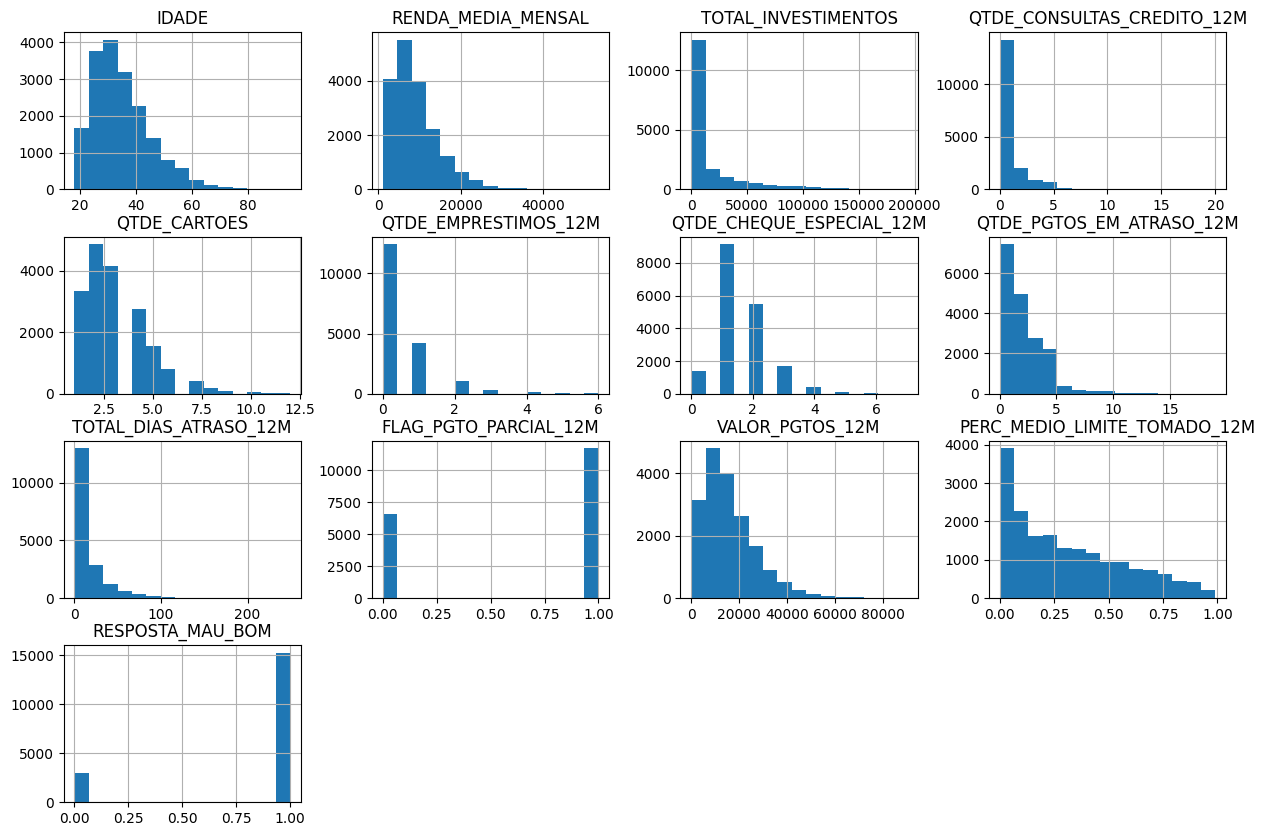

In [7]:
# plotar o histograma das variáveis numéricas
dados_credito.hist(bins=15, figsize=(15,10));

Analisando os histogramas das variáveis explicativas, podemos identificar que a maioria das variáveis "X's" provavelmente não seguem uma distribuição normal.

A não-normalidade e a natureza mista dos dados (contínuos, discretos, binários) reforçam a necessidade de uma abordagem cuidadosa na modelagem e   próximas análises. Porém, é importante destacar que a regressão logística ainda é apropriada.

In [8]:
print(dados_credito.describe())

              IDADE  RENDA_MEDIA_MENSAL  TOTAL_INVESTIMENTOS  \
count  18258.000000        18258.000000         18258.000000   
mean      34.990141         9003.762734         17937.605433   
std       10.339725         5656.668298         31770.763652   
min       18.000000         1100.000000             0.000000   
25%       27.000000         4800.000000           100.000000   
50%       33.000000         7700.000000          2600.000000   
75%       40.000000        11700.000000         20500.000000   
max       95.000000        53400.000000        193100.000000   

       QTDE_CONSULTAS_CREDITO_12M  QTDE_CARTOES  QTDE_EMPRESTIMOS_12M  \
count                18258.000000  18258.000000          18258.000000   
mean                     0.944134      3.033027              0.442655   
std                      1.446439      1.718050              0.778556   
min                      0.000000      1.000000              0.000000   
25%                      0.000000      2.000000           

**Quanto ao resumo estatístico acima,** 

Há uma grande variabilidade na renda mensal e nos investimentos dos clientes, o que sugere **diferentes perfis financeiros dentro da base de dados.**                                                                                        
A maioria dos clientes utiliza entre 2 a 4 cartões de crédito, com uma baixa quantidade de empréstimos.                                          
Um percentual significativo dos clientes tem registros de atrasos em pagamentos, o que pode ser um ponto crítico para avaliação de risco de crédito.

### **(d). Como os dados categóricos estão distribuidos ?** 

In [9]:
# Análise de frequências
print(dados_credito['SAFRA'].value_counts(normalize=True))
print(dados_credito['FLAG_PGTO_PARCIAL_12M'].value_counts(normalize=True))
print(dados_credito['RESPOSTA_MAU_BOM'].value_counts(normalize=True)) 

SAFRA
Safra 2    0.386680
Safra 3    0.315369
Safra 1    0.297952
Name: proportion, dtype: float64
FLAG_PGTO_PARCIAL_12M
1    0.640651
0    0.359349
Name: proportion, dtype: float64
RESPOSTA_MAU_BOM
1    0.837605
0    0.162395
Name: proportion, dtype: float64


#### Pareceres iniciais: Distribuição das Variáveis Categóricas

**Distribuição das Variáveis Categóricas**
**Safra:** Aproximadamente 39% dos clientes são da safra 2, 31% da safra 3, e 30% da safra 1, o que indica uma distribuição relativamente uniforme.
**Pagamentos Parciais:** 64% dos clientes não realizam pagamentos parciais, enquanto 36% realizam, o que pode ser um indicador de dificuldade financeira para uma parte significativa dos clientes.
**Resposta Mau/Bom:** Cerca de 84% dos clientes são classificados como “bom” pagador, e 16% como “mau” pagador. Esse desbalanceamento sugere uma atenção maior com relação a definição do ponto de corte e análises posteriores.

### **(d). Qual é o poder preditivo de cada variável em relação à variável dependente? Existe alguma(s) variáveis candidatas a serem descartadas do modelo?**  

In [10]:
# Lista de variáveis independentes
variaveis = ['IDADE', 'RENDA_MEDIA_MENSAL', 'TOTAL_INVESTIMENTOS',
             'QTDE_CONSULTAS_CREDITO_12M', 'QTDE_CARTOES',
             'QTDE_EMPRESTIMOS_12M', 'QTDE_CHEQUE_ESPECIAL_12M',
             'QTDE_PGTOS_EM_ATRASO_12M', 'TOTAL_DIAS_ATRASO_12M',
             'FLAG_PGTO_PARCIAL_12M', 'VALOR_PGTOS_12M',
             'PERC_MEDIO_LIMITE_TOMADO_12M']

# Calcular o IV para cada variável
iv_df = sc.iv(dados_credito, y='RESPOSTA_MAU_BOM', x=variaveis)
print(iv_df)

                        variable  info_value
2            TOTAL_INVESTIMENTOS    0.287148
8          TOTAL_DIAS_ATRASO_12M    0.237618
5           QTDE_EMPRESTIMOS_12M    0.201296
10               VALOR_PGTOS_12M    0.178416
7       QTDE_PGTOS_EM_ATRASO_12M    0.157347
1             RENDA_MEDIA_MENSAL    0.141239
4                   QTDE_CARTOES    0.140529
9          FLAG_PGTO_PARCIAL_12M    0.140170
6       QTDE_CHEQUE_ESPECIAL_12M    0.105160
11  PERC_MEDIO_LIMITE_TOMADO_12M    0.049788
3     QTDE_CONSULTAS_CREDITO_12M    0.048438
0                          IDADE    0.035867


#### Pareceres iniciais: Resultados índices IV

As variáveis TOTAL_INVESTIMENTOS, TOTAL_DIAS_ATRASO_12M, QTDE_EMPRESTIMOS_12M e VALOR_PGTOS_12M são as mais relevantes para prever o comportamento de risco, todas com poder preditivo médio. Isso significa que elas têm uma boa capacidade de discriminar entre clientes "bons" e "maus" pagadores.
As variáveis com baixo poder preditivo (como IDADE e QTDE_CONSULTAS_CREDITO_12M) têm pouca influência na modelagem preditiva e podem ser descartadas ou tratadas com menos importância em uma análise mais robusta.

Referência:
Quanto maior o IV (Information Value) de uma variável explicativa, maior o grau de associação entre ela e a variável resposta.                           A tabela a seguir propõe uma interpretação acerca do grau de associação para diferentes patamares de IV:

| Valor IV              | Associação     |
|-----------------------|----------------|
| IV ≥ 0,50             | Excelente      |
| 0,30 ≤ IV < 0,50      | Forte          |
| 0,10 ≤ IV < 0,30      | Média          |
| 0,02 ≤ IV < 0,10      | Fraca          |
| IV < 0,02             | Muito fraca    |

Para complementar a análise anterior, vamos analisar o comportamento dos dados em relação a variável resposta por meio de análises gráficas bivariadas ou seja, variável resposta vs. variáveis explicativas. Bem como analisar se são estatisticamente significantes em relação a diferença entre um bom pagador e mau pagador, adequando métodos de acordo com a normalidade dos dados. 

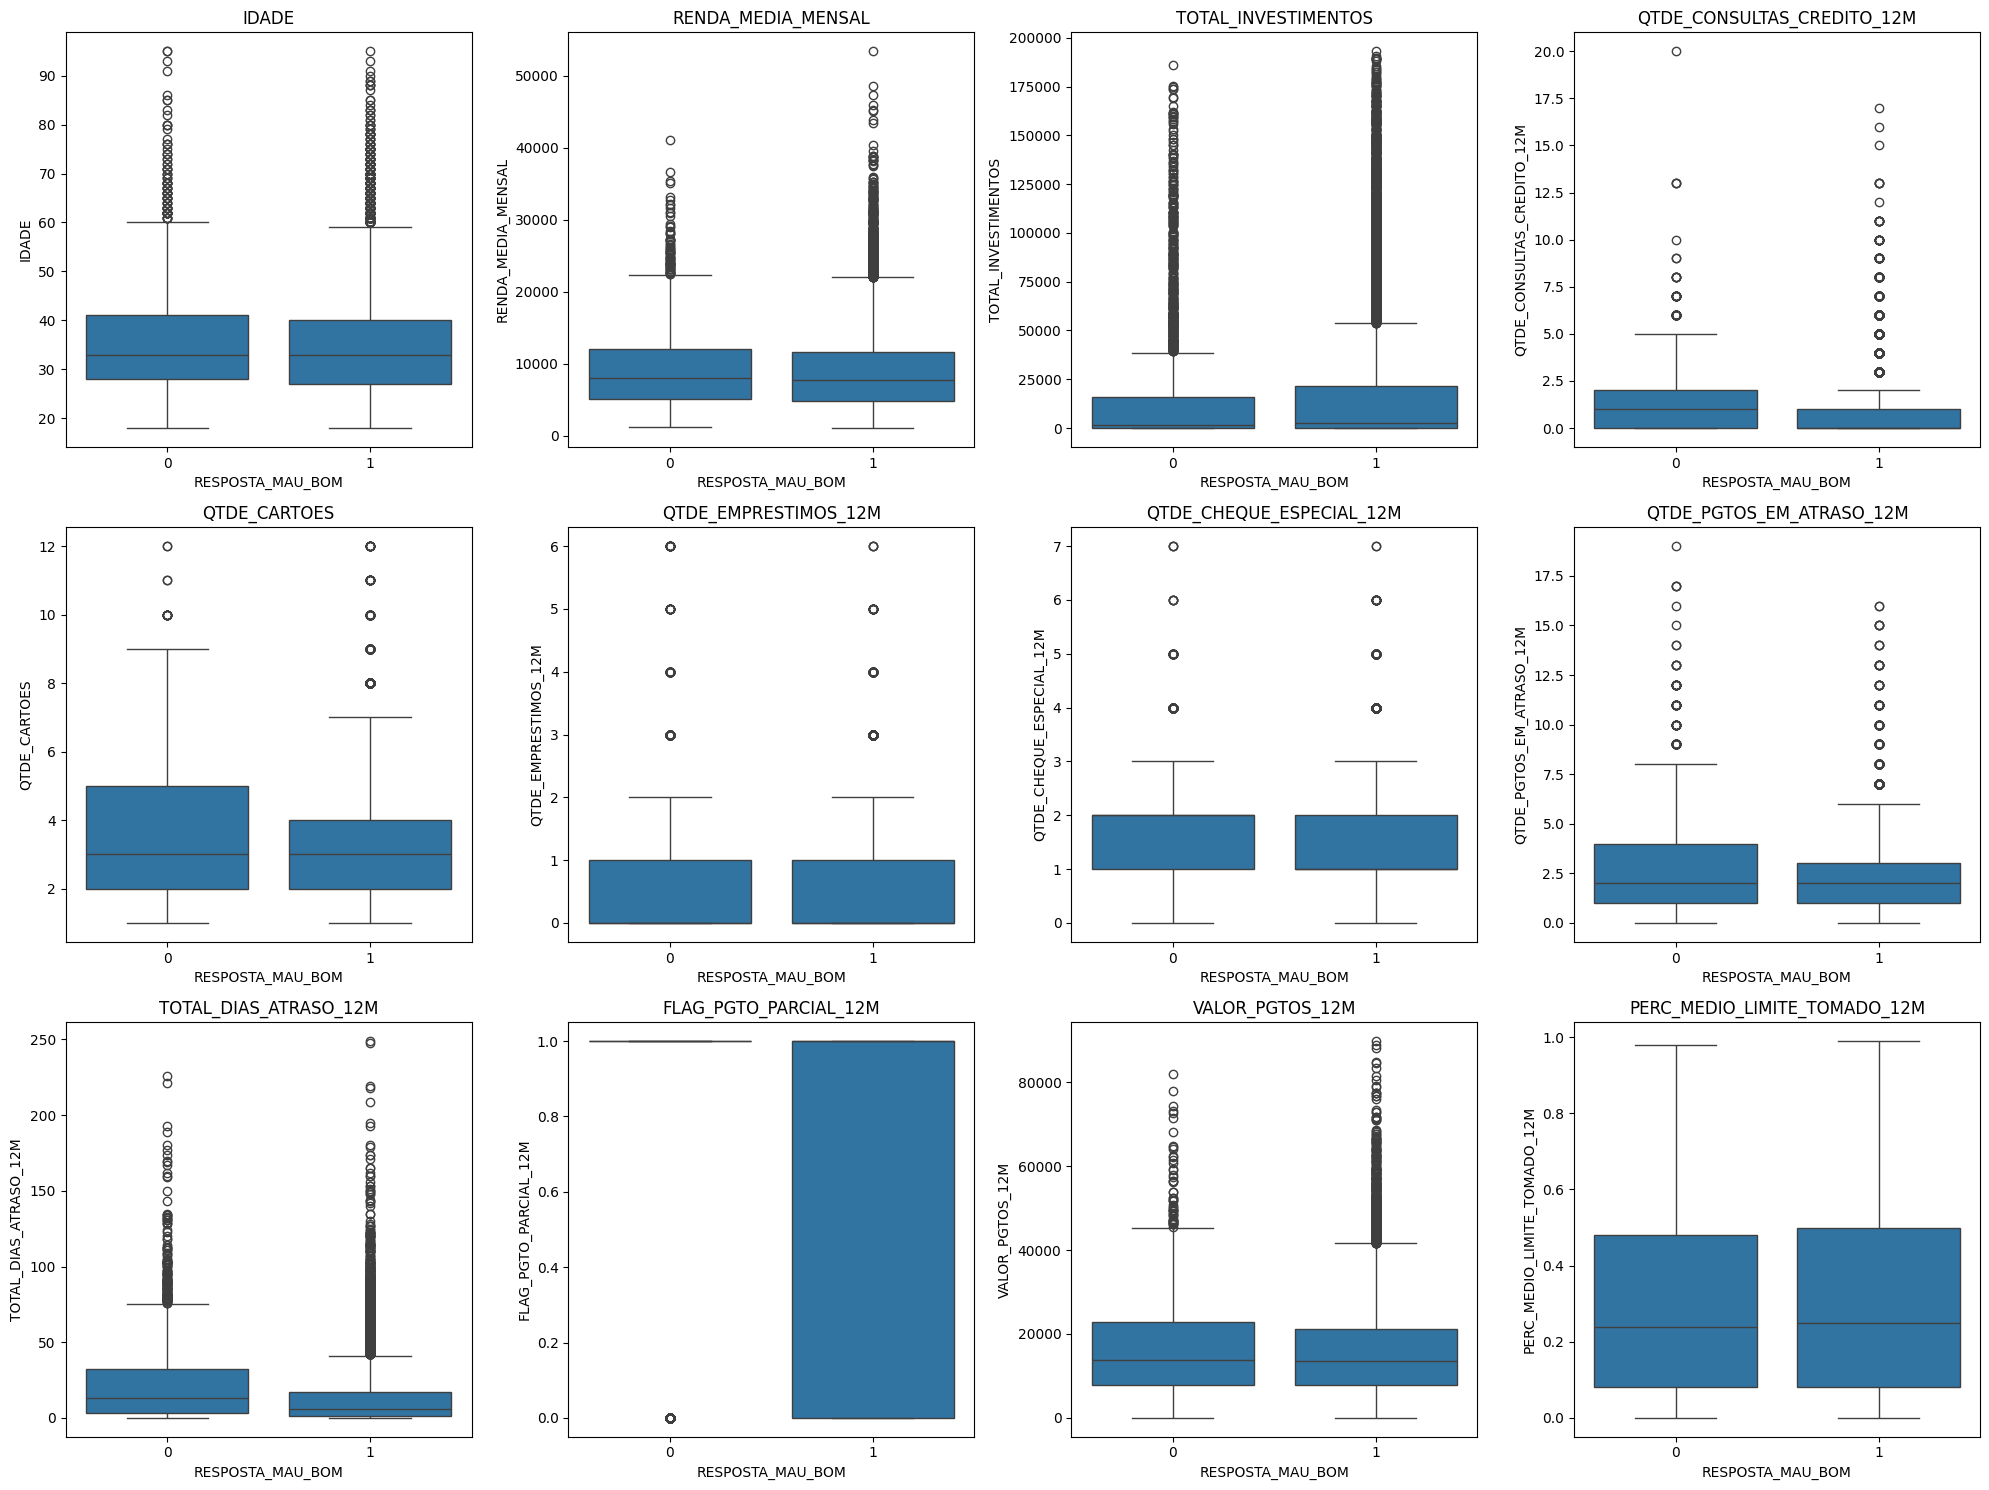

In [11]:
# Análise bivariada: variável resposta vs. variáveis explicativas
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

for i, col in enumerate(dados_credito.columns[2:-1]):  # Excluindo ID, SAFRA e a variável resposta
    sns.boxplot(x='RESPOSTA_MAU_BOM', y=col, data=dados_credito, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

### Parecer inicial sobre: Estatística básica e inferêncial

Os principais indicadores que parecem diferenciar "bons" e "maus" pagadores são:

**(1)Quantidade de Pagamentos em Atraso** e **(2)Total de Dias em Atraso:** Essas variáveis estão claramente mais elevadas para "maus" pagadores;

**(3)Flag de Pagamento Parcial:** Mais frequente entre "maus" pagadores, sugerindo dificuldades financeiras;

Essas variáveis serão provavelmente as mais relevantes na modelagem do score de crédito, enquanto variáveis como idade, renda e quantidade de empréstimos a princípio não têm muita influência. Como as medianas estão bem próximas e com o cuidado de verificar que a maioria dos dados não são normais, vou conduzir alguns testes estatísticos para avaliar a relação  entre as variáveis e confirmar as hipotéses que foram levantadas até o momento.  


Análise da variável: IDADE
Teste Mann-Whitney U: p-value = 0.1300
Correlação de Spearman: -0.0112 (p-value: 0.1300)

Análise da variável: RENDA_MEDIA_MENSAL
Teste Mann-Whitney U: p-value = 0.0000
Correlação de Spearman: -0.0321 (p-value: 0.0000)

Análise da variável: TOTAL_INVESTIMENTOS
Teste Mann-Whitney U: p-value = 0.0000
Correlação de Spearman: 0.0358 (p-value: 0.0000)

Análise da variável: QTDE_CONSULTAS_CREDITO_12M
Teste Mann-Whitney U: p-value = 0.0000
Correlação de Spearman: -0.0751 (p-value: 0.0000)

Análise da variável: QTDE_CARTOES
Teste Mann-Whitney U: p-value = 0.0000
Correlação de Spearman: -0.1230 (p-value: 0.0000)

Análise da variável: QTDE_EMPRESTIMOS_12M
Teste Mann-Whitney U: p-value = 0.0000
Correlação de Spearman: -0.1662 (p-value: 0.0000)

Análise da variável: QTDE_CHEQUE_ESPECIAL_12M
Teste Mann-Whitney U: p-value = 0.0000
Correlação de Spearman: -0.1163 (p-value: 0.0000)

Análise da variável: QTDE_PGTOS_EM_ATRASO_12M
Teste Mann-Whitney U: p-value = 0.0000
Correla

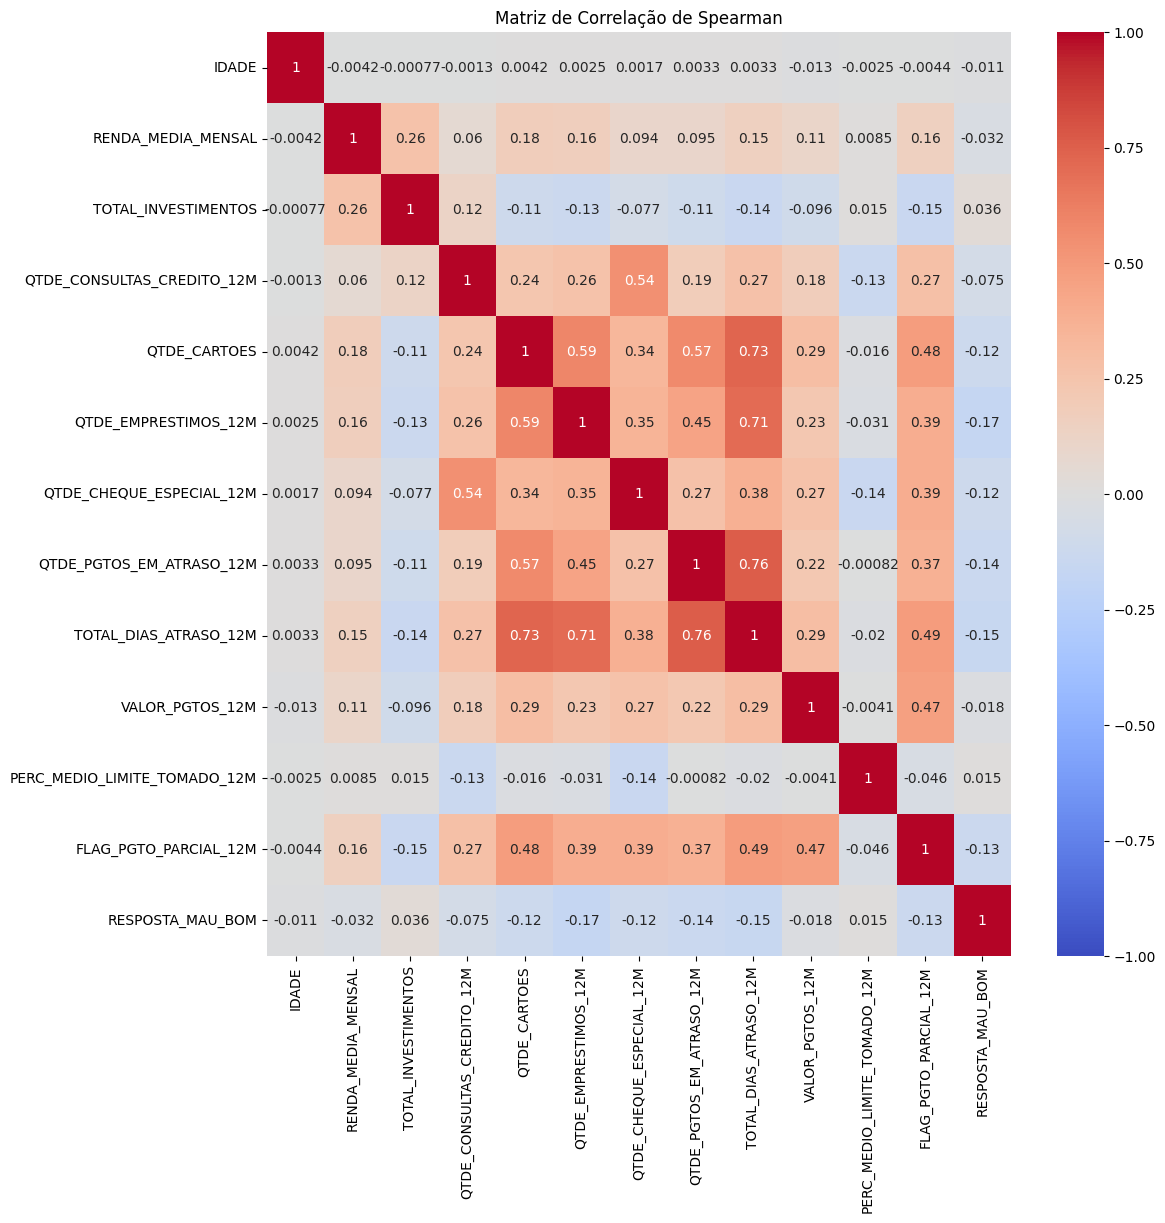

In [12]:
def analyze_variable(data, var, target='RESPOSTA_MAU_BOM'):
    print(f"\nAnálise da variável: {var}")
    
    # Teste de Mann-Whitney U
    good = data[data[target] == 1][var]
    bad = data[data[target] == 0][var]
    stat, p = stats.mannwhitneyu(good, bad, alternative='two-sided')
    print(f"Teste Mann-Whitney U: p-value = {p:.4f}")
    
    # Correlação de Spearman
    corr, p_corr = stats.spearmanr(data[var], data[target])
    print(f"Correlação de Spearman: {corr:.4f} (p-value: {p_corr:.4f})")
    
    # Teste Qui-quadrado para variáveis binárias/categóricas
    if data[var].nunique() <= 5:  # Assumindo que variáveis com 5 ou menos categorias são categóricas
        contingency = pd.crosstab(data[var], data[target])
        chi2, p_chi2, dof, expected = stats.chi2_contingency(contingency)
        print(f"Teste Qui-quadrado: p-value = {p_chi2:.4f}")
    
# Lista de variáveis para análise
variables = ['IDADE', 'RENDA_MEDIA_MENSAL', 'TOTAL_INVESTIMENTOS', 'QTDE_CONSULTAS_CREDITO_12M',
             'QTDE_CARTOES', 'QTDE_EMPRESTIMOS_12M', 'QTDE_CHEQUE_ESPECIAL_12M',
             'QTDE_PGTOS_EM_ATRASO_12M', 'TOTAL_DIAS_ATRASO_12M', 'VALOR_PGTOS_12M',
             'PERC_MEDIO_LIMITE_TOMADO_12M', 'FLAG_PGTO_PARCIAL_12M']

# Aplicar a análise para cada variável
for var in variables:
    analyze_variable(dados_credito, var)

# Matriz de correlação de Spearman
correlation_matrix = dados_credito[variables + ['RESPOSTA_MAU_BOM']].corr(method='spearman')
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlação de Spearman')
plt.show()

### Parecer inicial: Testes não paramétricos

As variáveis relacionadas a atrasos, empréstimos e uso de crédito (como QTDE_EMPRESTIMOS_12M, TOTAL_DIAS_ATRASO_12M) parecem ser os melhores preditores do status de bom/mau pagador.
Variáveis financeiras como RENDA_MEDIA_MENSAL e TOTAL_INVESTIMENTOS, embora significativas, têm correlações mais fracas do que esperado.
A IDADE não parece ser um fator significativo neste modelo.
Todas as variáveis, exceto IDADE, mostram diferenças significativas entre bons e maus pagadores, mas a força das correlações varia consideravelmente.

**Fundamentação técnica dos métodos utilizados**

Teste de Mann-Whitney U:

Escolhido porque:

Nossos dados não seguem uma distribuição normal, como observamos nos histogramas.
Queremos comparar as distribuições de variáveis contínuas ou ordinais entre dois grupos independentes (bons pagadores vs. maus pagadores).
É um teste não paramétrico, o que o torna mais robusto contra outliers e adequado para distribuições não normais.

Correlação de Spearman:

Escolhida porque:

Mede a força e direção de associações monotônicas, não apenas lineares.
É adequada para variáveis ordinais ou contínuas não normalmente distribuídas.
É menos sensível a outliers do que a correlação de Pearson.

Alternativa não utilizada:

Correlação de Pearson: Não foi escolhida porque assume relações lineares e é mais sensível a outliers.


Teste Qui-Quadrado:

Escolhido porque:

Temos variáveis categóricas (como FLAG_PGTO_PARCIAL_12M) que precisamos analisar em relação à variável resposta.
É adequado para testar a independência entre variáveis categóricas.
Não faz suposições sobre a distribuição dos dados.

### Parecer inicial: Análise de correlação das variáveis explicativas versus respota

As variáveis relacionadas ao histórico de crédito e pagamentos (empréstimos, atrasos, uso de cheque especial) parecem ser os melhores preditores do status de mau pagador.
Existe potencial multicolinearidade entre algumas variáveis, vamos verificar esse ponto por meio do índice "VIF".
Variáveis demográficas como IDADE e algumas variáveis financeiras como PERC_MEDIO_LIMITE_TOMADO_12M parecem ter pouco poder preditivo.
A relação negativa entre a maioria das variáveis e RESPOSTA_MAU_BOM sugere que comportamentos de maior risco (mais empréstimos, mais atrasos) estão associados a uma maior probabilidade de ser mau pagador.

# Construção do Modelo de Regressão Logística Múltipla

## Modelo 1: Considerando todas as variáveis

Com as análises anterioriores, provavelmente vamos descartar do modelo algumas variáveis como "Idade". Como também avaliar cuidadosamente o efeito de multicolineraridade. Como estratégia inicial, vamos realizar o modelo completo considerando todas as variáveis explicativas avaliando a significância de cada variável, como 95% de confiança. 

In [13]:
# Lista de todas as variáveis explicativas
todas_variaveis = ['IDADE', 'RENDA_MEDIA_MENSAL', 'TOTAL_INVESTIMENTOS', 'QTDE_CONSULTAS_CREDITO_12M',
                   'QTDE_CARTOES', 'QTDE_EMPRESTIMOS_12M', 'QTDE_CHEQUE_ESPECIAL_12M',
                   'QTDE_PGTOS_EM_ATRASO_12M', 'TOTAL_DIAS_ATRASO_12M', 'VALOR_PGTOS_12M',
                   'PERC_MEDIO_LIMITE_TOMADO_12M', 'FLAG_PGTO_PARCIAL_12M']

# Modelo 1: Com todas as variáveis
formula_todas = 'RESPOSTA_MAU_BOM ~ ' + ' + '.join(todas_variaveis)
modelo_todas = logit(formula_todas, data=dados_credito).fit()

print("Modelo com todas as variáveis:")
print(modelo_todas.summary())

Optimization terminated successfully.
         Current function value: 0.421003
         Iterations 6
Modelo com todas as variáveis:
                           Logit Regression Results                           
Dep. Variable:       RESPOSTA_MAU_BOM   No. Observations:                18258
Model:                          Logit   Df Residuals:                    18245
Method:                           MLE   Df Model:                           12
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                 0.05098
Time:                        18:01:48   Log-Likelihood:                -7686.7
converged:                       True   LL-Null:                       -8099.6
Covariance Type:            nonrobust   LLR p-value:                4.705e-169
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        2.4960  

#### (a) O que podemos concluir do primeiro modelo de regressão logistica proposto?

**Significância do Modelo:**

O modelo como um todo é estatisticamente significativo (LLR p-value: 4.705e-169), 
indicando que as variáveis independentes, coletivamente, têm poder preditivo.

**Qualidade do Ajuste:**

O Pseudo R-quadrado é 0.05098, o que sugere que o modelo explica aproximadamente 5.1% da variância na variável dependente. 
Este valor é relativamente baixo, indicando que pode haver outros fatores não incluídos no modelo que influenciam o status de bom/mau pagador. 

Nota explicativa: 
Valores entre 0.2 e 0.4 são geralmente considerados indicativos de um ajuste muito bom do modelo, segundo McFadden (1977).
Valores acima de 0.4 são raros em aplicações práticas.
Referência: 
McFadden, D. (1977). Quantitative Methods for Analyzing Travel Behavior of Individuals: Some Recent Developments. 
Cowles Foundation Discussion Paper No. 474.

**Variáveis Não Significativas considerando outras métricas que analisamos também:**

| Variável                      | p-Valor | Information Value (IV) | Variance Inflation Factor (VIF) |
|-------------------------------|---------|------------------------|--------------------------------|
| IDADE                         | 0.088   | 0.035867               | 1.000457                       |
| RENDA_MEDIA_MENSAL            | 0.656   | 0.141239               | 1.083444                       |
| QTDE_CONSULTAS_CREDITO_12M    | 0.973   | 0.048438               | 1.439380                       |
| QTDE_CARTOES                  | 0.711   | 0.140529               | 1.636529                       |
| TOTAL_DIAS_ATRASO_12M         | 0.480   | 0.237618               | 2.270238                       |
| PERC_MEDIO_LIMITE_TOMADO_12M  | 0.859   | 0.049788               | 1.032420                       |

**Considerações:**

Em caráter exploratório, vamos ver se trabalhando com classificações/faixas dessas variáveis conseguimos trazer alguma significância para o modelo de regressão em relação para essas variáveis, apesar da baixa probabilidade conseguirmos, devido ao baixo IV e p-value fora do intervalo
de confiança de 95% que buscamos. 

In [14]:
# Lista de variáveis independentes
variaveis_vif = ['IDADE', 'RENDA_MEDIA_MENSAL', 'TOTAL_INVESTIMENTOS',
                 'QTDE_CONSULTAS_CREDITO_12M', 'QTDE_CARTOES',
                 'QTDE_EMPRESTIMOS_12M', 'QTDE_CHEQUE_ESPECIAL_12M',
                 'QTDE_PGTOS_EM_ATRASO_12M', 'TOTAL_DIAS_ATRASO_12M',
                 'VALOR_PGTOS_12M', 'PERC_MEDIO_LIMITE_TOMADO_12M',
                 'FLAG_PGTO_PARCIAL_12M']

# Preparar os dados para o cálculo do VIF
X = dados_credito[variaveis_vif].dropna()

# Adicionar constante
X['const'] = 1

# Criar um DataFrame para armazenar os valores de VIF
vif = pd.DataFrame()
vif['Variável'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i)
              for i in range(len(X.columns))]

# Remover a constante dos resultados
vif = vif[vif['Variável'] != 'const']

# Exibir os resultados
print(vif)

                        Variável       VIF
0                          IDADE  1.000457
1             RENDA_MEDIA_MENSAL  1.083444
2            TOTAL_INVESTIMENTOS  1.155104
3     QTDE_CONSULTAS_CREDITO_12M  1.439830
4                   QTDE_CARTOES  1.636529
5           QTDE_EMPRESTIMOS_12M  1.905179
6       QTDE_CHEQUE_ESPECIAL_12M  1.481606
7       QTDE_PGTOS_EM_ATRASO_12M  1.538554
8          TOTAL_DIAS_ATRASO_12M  2.270238
9                VALOR_PGTOS_12M  1.284578
10  PERC_MEDIO_LIMITE_TOMADO_12M  1.032340
11         FLAG_PGTO_PARCIAL_12M  1.510594


### Verificando se as variáveis aprensentam multicolinearidade com o índice VIF(Variance Inflation Factor)

#### Análise dos VIFs:
Todos os valores de VIF estão abaixo de 5, indicando que não há problema significativo de multicolinearidade entre as variáveis independentes.
O VIF mais alto é de 2,27 para TOTAL_DIAS_ATRASO_12M, na literatura, indices próximos a 2 já podem indicar alguma multivolinearidade e quando analisamos a correlação de spearman que fizemos provavelmente a um indicativo. Porém, ainda bem abaixo do limite de preocupação comum (geralmente VIF > 5). Para o próximo modelo de regressão ainda vou manter

#### Categorização de variáveis:

• A proposta é realizar técnicas de **"Engenharia de Features"** realizando categorizações em relação às variáveis que vimos anteriormente que não são significativas, de modo a aumentar a qualidade da modelagem que estamos desenvolvendo.

• Por uma questão de contexto, vamos priorizar 3 variáveis que não foram significativas para realizar essa categorização:

  - Idade
  - Renda Média Mensal
  - Total de Dias em Atraso em outras instituições nos últimos 12 meses


#### Utilização de índices como: WoE e IV 

Para escolher o período que maximiza a relação entre cada variável explicativa e a variável resposta. Vamos utilizar como estratégia 2 índices o IV conforme relatado anteriormente e WoE "Weight of Evidence". 

Ao passo que o IV é uma medida geral do poder preditivo de toda a variável. O WoE me a "direção" em que uma categoria específica de 
uma variável está associada a a variável resposta binária. No nosso caso um WoE positivo indica que a categoria está mais associada 
a bons pagadores, enquanto um WoE negativo está mais associado a maus pagadores.


Referência: 
https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#usage_of_woe


#### Engenharia de Feature: Avaliação de faixas com a variável idade

In [15]:
def calcular_iv(df, feature, target):
    def iv_por_grupo(grupo):
        good = grupo[target].sum()
        bad = grupo[target].count() - good
        total_good = df[target].sum()
        total_bad = df[target].count() - total_good

        # Evitar divisão por zero e log de zero
        if good == 0 or bad == 0 or total_good == 0 or total_bad == 0 or (good / total_good == 0) or (bad / total_bad == 0):
            woe = 0
            iv = 0
            taxa_resposta = 0
            return pd.Series({'WOE': woe, 'IV': iv, 'Taxa de Resposta': taxa_resposta})

        percent_good = good / total_good
        percent_bad = bad / total_bad

        woe = np.log(percent_good / percent_bad)
        iv = (percent_good - percent_bad) * woe
        taxa_resposta = good / grupo[target].count()

        return pd.Series({'WOE': woe, 'IV': iv, 'Taxa de Resposta': taxa_resposta})

    stats = df.groupby(feature).apply(iv_por_grupo).reset_index()
    total_iv = stats['IV'].sum()

    return stats, total_iv

# Função para formatar o intervalo
def formatar_intervalo(intervalo):
    return f"{intervalo.left:.0f}-{intervalo.right:.0f}"

# Análise de TOTAL_DIAS_ATRASO_12M por faixas
print("Parte 1: Análise de TOTAL_DIAS_ATRASO_12M por faixas")

# Criar categorias para TOTAL_DIAS_ATRASO_12M
dados_credito['ATRASO_TERCIL'] = pd.qcut(dados_credito['TOTAL_DIAS_ATRASO_12M'], q=3, duplicates='drop')
dados_credito['ATRASO_QUARTIL'] = pd.qcut(dados_credito['TOTAL_DIAS_ATRASO_12M'], q=4, duplicates='drop')
dados_credito['ATRASO_QUINTIL'] = pd.qcut(dados_credito['TOTAL_DIAS_ATRASO_12M'], q=5, duplicates='drop')

# Remover linhas com NaN
colunas_atraso = ['ATRASO_TERCIL', 'ATRASO_QUARTIL', 'ATRASO_QUINTIL']
dados_credito_atraso = dados_credito.dropna(subset=colunas_atraso)

# Função para formatar a saída
def formatar_saida(stats, nome, iv_total, descricao):
    print(f"\nEstatísticas para {descricao}:")
    print(f"{'Faixa':<20}{'WOE':>10}{'IV':>10}{'Taxa de Resposta':>20}")
    print("-" * 60)
    for _, row in stats.iterrows():
        faixa = formatar_intervalo(row[nome])
        print(f"{faixa:<20}{row['WOE']:>10.4f}{row['IV']:>10.4f}{row['Taxa de Resposta']:>20.4f}")
    print(f"\nIV Total: {iv_total:.6f}")

# Calcular e exibir resultados para TOTAL_DIAS_ATRASO_12M
categorias_atraso = [
    ('ATRASO_TERCIL', 'Total de Dias em Atraso (Tercil)'),
    ('ATRASO_QUARTIL', 'Total de Dias em Atraso (Quartil)'),
    ('ATRASO_QUINTIL', 'Total de Dias em Atraso (Quintil)')
]

for categoria, descricao in categorias_atraso:
    stats, iv_total = calcular_iv(dados_credito_atraso, categoria, 'RESPOSTA_MAU_BOM')
    formatar_saida(stats, categoria, iv_total, descricao)


Parte 1: Análise de TOTAL_DIAS_ATRASO_12M por faixas

Estatísticas para Total de Dias em Atraso (Tercil):
Faixa                      WOE        IV    Taxa de Resposta
------------------------------------------------------------
-0-3                    0.4374    0.0617              0.8887
3-14                    0.1020    0.0031              0.8510
14-249                 -0.4606    0.0788              0.7649

IV Total: 0.143545

Estatísticas para Total de Dias em Atraso (Quartil):
Faixa                      WOE        IV    Taxa de Resposta
------------------------------------------------------------
-0-1                    0.5485    0.0622              0.8993
1-7                     0.1691    0.0075              0.8593
7-19                    0.0360    0.0003              0.8424
19-249                 -0.5577    0.0923              0.7470

IV Total: 0.162235

Estatísticas para Total de Dias em Atraso (Quintil):
Faixa                      WOE        IV    Taxa de Resposta
--------------

Mesmo com a categorização da idade, não é observado alguma faixa relevante para o modelo, apresentando índices de IV abaixo de 0,02
considerado assim uma relação muito fraca com a variável resposta. 

#### Engenharia de Feature: Avaliação da variável renda média mensal 

In [16]:
def calcular_iv(df, feature, target):
    def iv_por_grupo(grupo):
        good = grupo[target].sum()
        bad = grupo[target].count() - good
        total_good = df[target].sum()
        total_bad = df[target].count() - total_good

        # Evitar divisão por zero
        if total_good == 0 or total_bad == 0:
            woe = 0
            iv = 0
            taxa_resposta = 0
            return pd.Series({'WOE': woe, 'IV': iv, 'Taxa de Resposta': taxa_resposta})

        # Calcular percentuais
        percent_good = good / total_good
        percent_bad = bad / total_bad

        # Evitar log de zero ou divisão por zero
        if good == 0 or bad == 0 or percent_good == 0 or percent_bad == 0:
            woe = 0
            iv = 0
        else:
            woe = np.log(percent_good / percent_bad)
            iv = (percent_good - percent_bad) * woe

        taxa_resposta = good / grupo[target].count()

        return pd.Series({'WOE': woe, 'IV': iv, 'Taxa de Resposta': taxa_resposta})

    stats = df.groupby(feature).apply(iv_por_grupo).reset_index()
    total_iv = stats['IV'].sum()

    return stats, total_iv

# Função para formatar o intervalo de renda
def formatar_intervalo(intervalo):
    return f"{intervalo.left:.0f}-{intervalo.right:.0f}"

# Criando as divisões para RENDA_MEDIA_MENSAL
dados_credito['RENDA_TERCIL'] = pd.qcut(dados_credito['RENDA_MEDIA_MENSAL'], q=3)
dados_credito['RENDA_QUARTIL'] = pd.qcut(dados_credito['RENDA_MEDIA_MENSAL'], q=4)
dados_credito['RENDA_QUINTIL'] = pd.qcut(dados_credito['RENDA_MEDIA_MENSAL'], q=5)

# Removendo linhas com valores NaN nas novas colunas
dados_credito = dados_credito.dropna(subset=['RENDA_TERCIL', 'RENDA_QUARTIL', 'RENDA_QUINTIL'])

# Calculando as estatísticas para cada divisão
stats_tercil, iv_tercil = calcular_iv(dados_credito, 'RENDA_TERCIL', 'RESPOSTA_MAU_BOM')
stats_quartil, iv_quartil = calcular_iv(dados_credito, 'RENDA_QUARTIL', 'RESPOSTA_MAU_BOM')
stats_quintil, iv_quintil = calcular_iv(dados_credito, 'RENDA_QUINTIL', 'RESPOSTA_MAU_BOM')

# Função para formatar a saída
def formatar_saida(stats, nome, iv_total):
    print(f"\nEstatísticas por {nome} de Renda Média Mensal:")
    print(f"{'Faixa de Renda':<20}{'WOE':>10}{'IV':>10}{'Taxa de Resposta':>20}")
    print("-" * 60)
    for _, row in stats.iterrows():
        faixa_renda = formatar_intervalo(row[nome])
        print(f"{faixa_renda:<20}{row['WOE']:>10.4f}{row['IV']:>10.4f}{row['Taxa de Resposta']:>20.4f}")
    print(f"\nIV Total ({nome}): {iv_total:.6f}")

# Exibindo os resultados
formatar_saida(stats_tercil, 'RENDA_TERCIL', iv_tercil)
formatar_saida(stats_quartil, 'RENDA_QUARTIL', iv_quartil)
formatar_saida(stats_quintil, 'RENDA_QUINTIL', iv_quintil)



Estatísticas por RENDA_TERCIL de Renda Média Mensal:
Faixa de Renda             WOE        IV    Taxa de Resposta
------------------------------------------------------------
1100-5700               0.1229    0.0049              0.8536
5700-10200             -0.0499    0.0009              0.8307
10200-53400            -0.0666    0.0015              0.8283

IV Total (RENDA_TERCIL): 0.007197

Estatísticas por RENDA_QUARTIL de Renda Média Mensal:
Faixa de Renda             WOE        IV    Taxa de Resposta
------------------------------------------------------------
1100-4800               0.1904    0.0085              0.8619
4800-7700              -0.0574    0.0008              0.8297
7700-11700             -0.0457    0.0005              0.8313
11700-53400            -0.0720    0.0013              0.8276

IV Total (RENDA_QUARTIL): 0.011186

Estatísticas por RENDA_QUINTIL de Renda Média Mensal:
Faixa de Renda             WOE        IV    Taxa de Resposta
---------------------------------

A distribuição de renda também segue a mesma conclusão anterior, a princípio não há nenhuma faixa ou valores que chamem a atenção para o modelo. 

In [17]:
def calcular_iv(df, feature, target):
    def iv_por_grupo(grupo):
        good = grupo[target].sum()
        bad = grupo[target].count() - good
        total_good = df[target].sum()
        total_bad = df[target].count() - total_good
        if total_good == 0 or total_bad == 0 or good == 0 or bad == 0:
            woe = 0
            iv = 0
            taxa_resposta = 0
        else:
            percent_good = good / total_good
            percent_bad = bad / total_bad
            if percent_good == 0 or percent_bad == 0:
                woe = 0
                iv = 0
            else:
                woe = np.log(percent_good / percent_bad)
                iv = (percent_good - percent_bad) * woe
            taxa_resposta = good / grupo[target].count()
        return pd.Series({'WOE': woe, 'IV': iv, 'Taxa de Resposta': taxa_resposta})
    stats = df.groupby(feature).apply(iv_por_grupo).reset_index()
    total_iv = stats['IV'].sum()
    return stats, total_iv

def formatar_saida(stats, nome, iv_total, descricao):
    print(f"\nEstatísticas para {descricao}:")
    print(f"{'Faixa':<20}{'WOE':>10}{'IV':>10}{'Taxa de Resposta':>20}")
    print("-" * 60)
    for _, row in stats.iterrows():
        faixa = str(row[nome])
        print(f"{faixa:<20}{row['WOE']:>10.4f}{row['IV']:>10.4f}{row['Taxa de Resposta']:>20.4f}")
    print(f"\nIV Total: {iv_total:.6f}")

# Análise com tercis
print("Análise de IDADE com tercis")
dados_credito['IDADE_TERCIL'] = pd.qcut(dados_credito['IDADE'], q=3, duplicates='drop')
dados_credito_idade_tercil = dados_credito.dropna(subset=['IDADE_TERCIL'])
stats_tercil, iv_total_tercil = calcular_iv(dados_credito_idade_tercil, 'IDADE_TERCIL', 'RESPOSTA_MAU_BOM')
formatar_saida(stats_tercil, 'IDADE_TERCIL', iv_total_tercil, 'Idade (Tercis)')

# Análise com quartis
print("\nAnálise de IDADE com quartis")
dados_credito['IDADE_QUARTIL'] = pd.qcut(dados_credito['IDADE'], q=4, duplicates='drop')
dados_credito_idade_quartil = dados_credito.dropna(subset=['IDADE_QUARTIL'])
stats_quartil, iv_total_quartil = calcular_iv(dados_credito_idade_quartil, 'IDADE_QUARTIL', 'RESPOSTA_MAU_BOM')
formatar_saida(stats_quartil, 'IDADE_QUARTIL', iv_total_quartil, 'Idade (Quartis)')

# Análise com quintis
print("\nAnálise de IDADE com quintis")
dados_credito['IDADE_QUINTIL'] = pd.qcut(dados_credito['IDADE'], q=5, duplicates='drop')
dados_credito_idade_quintil = dados_credito.dropna(subset=['IDADE_QUINTIL'])
stats_quintil, iv_total_quintil = calcular_iv(dados_credito_idade_quintil, 'IDADE_QUINTIL', 'RESPOSTA_MAU_BOM')
formatar_saida(stats_quintil, 'IDADE_QUINTIL', iv_total_quintil, 'Idade (Quintis)')

# Comparação dos IVs totais
print("\nComparação dos IVs Totais:")
print(f"Tercis: {iv_total_tercil:.6f}")
print(f"Quartis: {iv_total_quartil:.6f}")
print(f"Quintis: {iv_total_quintil:.6f}")

Análise de IDADE com tercis

Estatísticas para Idade (Tercis):
Faixa                      WOE        IV    Taxa de Resposta
------------------------------------------------------------
(17.999, 29.0]          0.0422    0.0006              0.8433
(29.0, 38.0]            0.0167    0.0001              0.8399
(38.0, 95.0]           -0.0648    0.0013              0.8286

IV Total: 0.002009

Análise de IDADE com quartis

Estatísticas para Idade (Quartis):
Faixa                      WOE        IV    Taxa de Resposta
------------------------------------------------------------
(17.999, 27.0]          0.0348    0.0003              0.8423
(27.0, 33.0]            0.0160    0.0001              0.8398
(33.0, 40.0]            0.0179    0.0001              0.8400
(40.0, 95.0]           -0.0672    0.0011              0.8283

IV Total: 0.001590

Análise de IDADE com quintis

Estatísticas para Idade (Quintis):
Faixa                      WOE        IV    Taxa de Resposta
---------------------------------

Em todas as categorizações, não observamos nenhuma relação que faça sentido avaliar em modelo devido a um baixo índice de IV.

## Modelo 2: Formulação da Equação do Modelo Final

Para o 2º Modelo, vamos adotar **somente** as variáveis que são estatisticamente significativas com 95% de confirança conforme indicado no Modelo 1 de Regressão. 


In [18]:
# Definir uma semente aleatória para reprodutibilidade
np.random.seed(42)

# Lista de variáveis significativas do modelo anterior
variaveis_significativas = [
    'TOTAL_INVESTIMENTOS',
    'QTDE_EMPRESTIMOS_12M',
    'QTDE_CHEQUE_ESPECIAL_12M',
    'QTDE_PGTOS_EM_ATRASO_12M',
    'VALOR_PGTOS_12M',
    'FLAG_PGTO_PARCIAL_12M'
]

# Preparar os dados
X = dados_credito[variaveis_significativas]
y = dados_credito['RESPOSTA_MAU_BOM']

# Remover linhas com valores nulos
X = X.dropna()
y = y.loc[X.index]

# Dividir os dados em conjuntos de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adicionar uma constante para o statsmodels (apenas para o conjunto de treino)
X_train_sm = sm.add_constant(X_train)

# Calcular VIF para as variáveis de treino
vif_data = pd.DataFrame()
vif_data["Variável"] = X_train_sm.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]

print("Valores VIF (conjunto de treino):")
print(vif_data.sort_values('VIF', ascending=False))
print("\n")

# Criar e ajustar o modelo de regressão logística
modelo_logistico = sm.Logit(y_train, X_train_sm)
resultados = modelo_logistico.fit()

# Exibir o resumo do modelo
print(resultados.summary())

# Exibir os odds ratios
print("\nOdds Ratios:")
print(np.exp(resultados.params))

# Salvar os conjuntos de treino e teste para uso futuro
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

Valores VIF (conjunto de treino):
                   Variável       VIF
0                     const  5.860276
6     FLAG_PGTO_PARCIAL_12M  1.440972
2      QTDE_EMPRESTIMOS_12M  1.284787
5           VALOR_PGTOS_12M  1.273211
4  QTDE_PGTOS_EM_ATRASO_12M  1.242040
3  QTDE_CHEQUE_ESPECIAL_12M  1.193284
1       TOTAL_INVESTIMENTOS  1.013989


Optimization terminated successfully.
         Current function value: 0.421426
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       RESPOSTA_MAU_BOM   No. Observations:                14606
Model:                          Logit   Df Residuals:                    14599
Method:                           MLE   Df Model:                            6
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                 0.04956
Time:                        18:01:49   Log-Likelihood:                -6155.4
converged:                       True   LL-Null:                       -6476.3
Covar

Todas as variáveis, exceto TOTAL_INVESTIMENTOS, são estatisticamente significativas (p-values < 0.05).
TOTAL_INVESTIMENTOS tem um p-value de 0.217, indicando que não é estatisticamente significativa neste modelo.
Vamos então retirar do modelo, e calcular novamente. Mantendo o mesmo modelo de treino. 

In [19]:
# Definir uma semente aleatória para reprodutibilidade
np.random.seed(42)

# Lista de variáveis significativas do modelo anterior
variaveis_significativas = [
    'QTDE_EMPRESTIMOS_12M',
    'QTDE_CHEQUE_ESPECIAL_12M',
    'QTDE_PGTOS_EM_ATRASO_12M',
    'VALOR_PGTOS_12M',
    'FLAG_PGTO_PARCIAL_12M'
]

# Preparar os dados
X = dados_credito[variaveis_significativas]
y = dados_credito['RESPOSTA_MAU_BOM']

# Remover linhas com valores nulos em X ou y
data = pd.concat([X, y], axis=1)
data = data.dropna()
X = data[variaveis_significativas]
y = data['RESPOSTA_MAU_BOM']

# Dividir os dados em conjuntos de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Adicionar uma constante para o statsmodels
X_train_sm = sm.add_constant(X_train)

# Calcular VIF para as variáveis de treino
vif_data = pd.DataFrame()
vif_data["Variável"] = X_train_sm.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])
]
print("Valores VIF (conjunto de treino):")
print(vif_data.sort_values('VIF', ascending=False))
print("\n")

# Criar e ajustar o modelo de regressão logística
modelo_logistico = sm.Logit(y_train.astype(float), X_train_sm.astype(float))
resultados = modelo_logistico.fit()

# Exibir o resumo do modelo
print(resultados.summary())

# Exibir os odds ratios
print("\nOdds Ratios:")
print(np.exp(resultados.params))


Valores VIF (conjunto de treino):
                   Variável       VIF
0                     const  5.444750
5     FLAG_PGTO_PARCIAL_12M  1.434535
1      QTDE_EMPRESTIMOS_12M  1.283228
4           VALOR_PGTOS_12M  1.272910
3  QTDE_PGTOS_EM_ATRASO_12M  1.240962
2  QTDE_CHEQUE_ESPECIAL_12M  1.188269


Optimization terminated successfully.
         Current function value: 0.421660
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       RESPOSTA_MAU_BOM   No. Observations:                14606
Model:                          Logit   Df Residuals:                    14600
Method:                           MLE   Df Model:                            5
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                 0.04903
Time:                        18:01:49   Log-Likelihood:                -6158.8
converged:                       True   LL-Null:                       -6476.3
Covariance Type:            nonrobust   LLR

Todos os resultados dos "VIFs" indicam que não há problemas sérios de multicolinearidade.

A remoção da variável TOTAL_INVESTIMENTOS não parece ter afetado significativamente o desempenho ou a interpretação do modelo. 
Todas as variáveis restantes continuam sendo preditores com significância estatística do comportamento de pagamento. 

## Avaliação de Desempenho do Modelo

#### Definição do ponto de corte do modelo - Base treino (80/20)

In [20]:
# 1. Calcular o ponto de corte usando a média da variável resposta na base de treino
ponto_corte_regra_geral = y_train.mean()
print(f"Ponto de corte (regra geral): {ponto_corte_regra_geral:.4f}")

Ponto de corte (regra geral): 0.8377


#### Análises dos indicadores de desempenho

In [21]:
# Prever probabilidades na base de teste
y_test_pred_proba = resultados.predict(sm.add_constant(X_test))

# Classificar usando o mesmo ponto de corte
y_test_pred = (y_test_pred_proba >= ponto_corte_regra_geral).astype(int)

# Calcular os indicadores na base de teste
cm_test = confusion_matrix(y_test, y_test_pred)
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

acuracia_test = accuracy_score(y_test, y_test_pred)
sensibilidade_test = tp_test / (tp_test + fn_test)
especificidade_test = tn_test / (tn_test + fp_test)
auc_test = roc_auc_score(y_test, y_test_pred_proba)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_proba)
ks_statistic_test = max(tpr_test - fpr_test)

print(f"\nIndicadores na Base de Teste com Ponto de Corte {ponto_corte_regra_geral:.4f}:")
print(f"Acurácia: {acuracia_test:.4f}")
print(f"Sensibilidade: {sensibilidade_test:.4f}")
print(f"Especificidade: {especificidade_test:.4f}")
print(f"AUC: {auc_test:.4f}")
print(f"KS Statistic: {ks_statistic_test:.4f}")


Indicadores na Base de Teste com Ponto de Corte 0.8377:
Acurácia: 0.6377
Sensibilidade: 0.6474
Especificidade: 0.5882
AUC: 0.6629
KS Statistic: 0.2465


In [27]:
def calcular_metricas(y_true, y_pred_proba, ponto_corte):
    y_pred = (y_pred_proba >= ponto_corte).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    acuracia = accuracy_score(y_true, y_pred)
    sensibilidade = tp / (tp + fn)
    especificidade = tn / (tn + fp)
    
    return acuracia, sensibilidade, especificidade

# Assumindo que X e y já foram definidos anteriormente
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adicionar uma constante para o statsmodels
X_train_sm = sm.add_constant(X_train)

# Ajustar o modelo
modelo_logistico = sm.Logit(y_train, X_train_sm)
resultados = modelo_logistico.fit()

# Calcular as probabilidades previstas para o conjunto de treinamento
y_train_pred_proba = resultados.predict(X_train_sm)

# Calculando o ponto de corte pela regra geral
ponto_corte_regra_geral = y_train.mean()

# Lista de pontos de corte para comparar
pontos_corte = [ponto_corte_regra_geral, 0.83, 0.84, 0.85, 0.86]

# Calculando métricas para cada ponto de corte
resultados_comparacao = []

for pc in pontos_corte:
    acuracia, sensibilidade, especificidade = calcular_metricas(y_train, y_train_pred_proba, pc)
    auc = roc_auc_score(y_train, y_train_pred_proba)
    fpr, tpr, _ = roc_curve(y_train, y_train_pred_proba)
    ks = max(tpr - fpr)
    resultados_comparacao.append((pc, acuracia, sensibilidade, especificidade, auc, ks))

# Convertendo resultados para DataFrame para fácil visualização
df_resultados = pd.DataFrame(resultados_comparacao, 
                             columns=['Ponto de Corte', 'Acurácia', 'Sensibilidade', 'Especificidade', 'AUC', 'KS'])

# Exibindo os resultados
print("Comparação dos Pontos de Corte:")
print(df_resultados.to_string(index=False))

# Avaliação no conjunto de teste
X_test_sm = sm.add_constant(X_test)
y_test_pred_proba = resultados.predict(X_test_sm)

# Usando o melhor ponto de corte encontrado (por exemplo, 0.84)
melhor_ponto_corte = 0.84
acuracia_teste, sensibilidade_teste, especificidade_teste = calcular_metricas(y_test, y_test_pred_proba, melhor_ponto_corte)
auc_teste = roc_auc_score(y_test, y_test_pred_proba)


Optimization terminated successfully.
         Current function value: 0.421660
         Iterations 6
Comparação dos Pontos de Corte:
 Ponto de Corte  Acurácia  Sensibilidade  Especificidade      AUC       KS
       0.837738  0.637204       0.646290        0.590295 0.653711 0.239894
       0.830000  0.659455       0.680778        0.549367 0.653711 0.239894
       0.840000  0.630357       0.636074        0.600844 0.653711 0.239894
       0.850000  0.589073       0.577149        0.650633 0.653711 0.239894
       0.860000  0.542791       0.512831        0.697468 0.653711 0.239894


### Conclusões sobre o modelo

#### Definição do ponto de corte
Analisando as propostas de ponto de corte, a que me parece ter uma proposta mais equilibrada e no nosso contexto 
como estamos olhando para o score de crédito, a especificidade que é a capacidade do modelo de identificar corretamente 
os maus pagadores é relevante. 

Portanto, vamos seguir com o ponto de corte de 0.84.

#### Análise dos indicadores e desempenho 
Considerando os parâmetros de referência o indicador de acurácia está no limiar de discriminância entre fraco/satisfatória,
sensibilidade também entre fraco/satisfatório e especificidade que ja se enquadrada mais como uma discriminância satisfatória. 

Quanto a KS e AuC está com um poder de discriminância aceitável. Mas, já fica como um ponto de atenção como próximos passos e 
reavaliar a modelegem buscando por novas variáveis, eng de features e outras estratégias. 

In [28]:
# Definição de ponto de corte
ponto_corte = 0.84  # Conforme definido anteriormente

# Aplicação do modelo no conjunto de treino
y_train_pred_proba = resultados.predict(X_train_sm)

# Definição da resposta predita pelo modelo
y_train_pred = (y_train_pred_proba > ponto_corte).astype(int)

# Análise de desempenho no conjunto de treino
def calcular_metricas(y_true, y_pred, y_pred_proba):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acuracia = accuracy_score(y_true, y_pred)
    especificidade = tn / (tn + fp)
    sensibilidade = tp / (tp + fn)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    ks = max(tpr - fpr)
    auc = roc_auc_score(y_true, y_pred_proba)
    return acuracia, especificidade, sensibilidade, ks, auc

metricas_treino = calcular_metricas(y_train, y_train_pred, y_train_pred_proba)

# Aplicação do modelo no conjunto de teste
X_test_sm = sm.add_constant(X_test)
y_test_pred_proba = resultados.predict(X_test_sm)
y_test_pred = (y_test_pred_proba > ponto_corte).astype(int)

# Análise de desempenho no conjunto de teste
metricas_teste = calcular_metricas(y_test, y_test_pred, y_test_pred_proba)

# Exibir resultados
print("Métricas na base de treino:")
print(f"Acurácia: {metricas_treino[0]:.4f}")
print(f"Especificidade: {metricas_treino[1]:.4f}")
print(f"Sensibilidade: {metricas_treino[2]:.4f}")
print(f"KS: {metricas_treino[3]:.4f}")
print(f"AUC: {metricas_treino[4]:.4f}")

print("\nMétricas na base de teste:")
print(f"Acurácia: {metricas_teste[0]:.4f}")
print(f"Especificidade: {metricas_teste[1]:.4f}")
print(f"Sensibilidade: {metricas_teste[2]:.4f}")
print(f"KS: {metricas_teste[3]:.4f}")
print(f"AUC: {metricas_teste[4]:.4f}")

Métricas na base de treino:
Acurácia: 0.6304
Especificidade: 0.6008
Sensibilidade: 0.6361
KS: 0.2399
AUC: 0.6537

Métricas na base de teste:
Acurácia: 0.6303
Especificidade: 0.6000
Sensibilidade: 0.6362
KS: 0.2465
AUC: 0.6629


## Considerações finais:

**Análise geral:**

- O modelo não apresenta sinais de "overfitting", já que o desempenho na base de teste é ligeiramente melhor em todas as métricas;
- O modelo apresenta um desempenho aceitável/modesto, com margens para melhorias em seu poder preditivo.

**Recomendações e próximos passos:**

- Calcular o score para um cliente específico e interpretar o resultado no contexto da política de crédito do banco;                                     
- Considerar a inclusão de novas variáveis preditivas ou a criação de features derivadas para melhorar o poder preditivo do modelo;                     
- Explorar técnicas de balanceamento de classes, pelas análises prévias a indícios de desequilíbrio entre bons e maus pagadores;           
- Testar outros algoritmos de machine learning (como Random Forest, Gradient Boosting) para ver se oferecem melhor desempenho. 
